# Identificación de transacciones financieras fraudulentas mediante técnicas de machine learning 

## Contexto.  

En nuestro proyecto, abordamos uno de los desafíos más críticos que enfrentan las instituciones financieras en la actualidad: la detección de fraude en transacciones bancarias. A medida que los sistemas financieros se digitalizan cada vez más, los métodos fraudulentos evolucionan en sofisticación, lo que hace necesario el desarrollo de sistemas de detección más robustos y adaptables. 

Nos enfrentamos a un problema complejo caracterizado por: 

- Datos altamente desbalanceados, donde las transacciones fraudulentas son eventos raros 

- Necesidad de procesamiento en tiempo real o casi real 

- Requerimiento de alta precisión para minimizar falsos positivos que podrían afectar a clientes legítimos 

- Necesidad de adaptación continua a nuevos patrones de fraude 

## Pregunta de negocio y alcance del proyecto.  

Nuestra pregunta de negocio es: ¿Cómo podemos desarrollar un sistema de detección de fraude que identifique eficazmente transacciones fraudulentas? 


Nuestra pregunta de analítica será: ¿Cuáles son los modelos de machine learning supervisados más efectivos para predecir transacciones fraudulentas, y qué variables (monto de la transacción, ubicación, categoría, etc.) son los predictores más importantes en la detección de fraude? 
 

El alcance de nuestro proyecto incluye: 

- Desarrollo de modelos de machine learning para clasificación de transacciones 

- Implementación de técnicas de análisis de datos para identificación de patrones 

- Evaluación de rendimiento usando métricas específicas para datos desbalanceados 

- Validación del modelo en un contexto simulado de transacciones bancarias 

- Visualización mediante un tablero de control  

## Descripción de conjuntos de datos

Trabajamos con datos generados por BankSim, un simulador de pagos bancarios basado en datos transaccionales agregados de un banco español. Este conjunto de datos presenta características únicas que lo hacen especialmente valioso para nuestro proyecto: 

**Volumen de datos:**
594,643 registros totales  
587,443 transacciones normales 
7,200 transacciones fraudulentas (aproximadamente 1.2% del total) 

**Periodo de simulación:** 180 ejecuciones en BankSim (equivalente a aproximadamente 6 meses) 

**Características del fraude simulado:**  

-Simulación de ladrones que intentan robar un promedio de tres tarjetas por ejecución 

-Aproximadamente dos transacciones fraudulentas por día por tarjeta comprometida 

La ventaja de utilizar estos datos simulados es que nos permiten trabajar con un conjunto que mantiene las características estadísticas de datos reales, pero sin comprometer información personal o confidencial, cumpliendo así con las regulaciones de privacidad mientras mantenemos la relevancia para el problema en cuestión. 

## Exploración de los datos.

In [1]:
## carga, lectura y procesamiento
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualización
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Modelos
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [10]:
data = pd.read_csv(r"fraud-detection\data\banksim.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


**Descripción del conjunto de datos:**
Se tienen 9 variables y la variable objetivo:

| **Columna**       | **Descripción**                                                                                                         | **Tipo de Datos** | **Valores/Notas**                                                                                   |
|-------------------|-------------------------------------------------------------------------------------------------------------------------|-------------------|------------------------------------------------------------------------------------------------------|
| **Step**          | Representa el día desde el inicio de la simulación. La simulación tiene 180 pasos, lo que equivale a 6 meses virtuales.  | Numérico          | 1-180                                                                                               |
| **Customer**      | Identificador único para cada cliente.                                                                                  | Texto             | Ejemplo: 'C1093826151'                                                                               |
| **zipCodeOrigin** | Código postal del origen o fuente de la transacción.                                                                     | Numérico          | Código postal de 5 dígitos                                                                           |
| **Merchant**      | Identificador único del comerciante.                                                                                     | Texto             | Ejemplo: 'M348934600'                                                                                |
| **zipMerchant**   | Código postal del comerciante.                                                                                           | Numérico          | Código postal de 5 dígitos                                                                           |
| **Age**           | Edad categorizada del cliente.                                                                                           | Numérico          | 0: <= 18, 1: 19-25, 2: 26-35, 3: 36-45, 4: 46-55, 5: 56-65, 6: > 65, U: Desconocido                   |
| **Gender**        | Género del cliente.                                                                                                      | Texto             | E: Empresa, F: Femenino, M: Masculino, U: Desconocido                                                |
| **Category**      | Categoría de la compra realizada.                                                                                        | Texto             | Ejemplo: 'es_transportation', 'es_health', etc.                                                      |
| **Amount**        | Monto de la transacción realizada.                                                                                       | Numérico          | Ejemplo: 4.55                                                                                        |
| **Fraud**         | Variable objetivo que indica si la transacción es fraudulenta (1) o benigna (0).                                          | Binario           | 1: Fraudulenta, 0: No fraudulenta                                                                    |


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Los datos de fraude suelen estar desbalanceados, como se observa. Para balancear el conjunto de datos, se pueden aplicar técnicas de sobremuestreo o submuestreo.

In [13]:
# Definir una paleta de colores en tonos azules, con distintas intensidades
blue_palette = ["#0D47A1", "#1976D2", "#42A5F5", "#90CAF9", "#BBDEFB"]

# Establecer la paleta de colores personalizada
sns.set_palette(sns.color_palette(blue_palette))

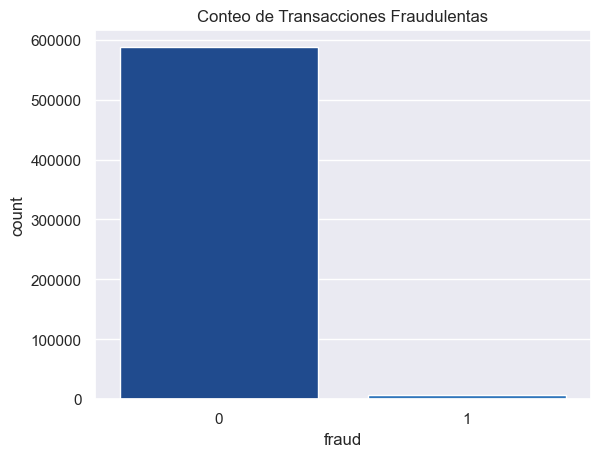

Número de ejemplos normales:  587443
Número de ejemplos fraudulentos:  7200


In [14]:
# Crear dos DataFrames separados, uno para transacciones fraudulentas y otro para transacciones no fraudulentas
df_fraud = data.loc[data.fraud == 1]  # Filtramos las transacciones que son fraudulentas (fraud == 1)
df_non_fraud = data.loc[data.fraud == 0]  # Filtramos las transacciones que no son fraudulentas (fraud == 0)

# Crear un gráfico de barras para contar el número de transacciones fraudulentas y no fraudulentas
sns.countplot(x="fraud", data=data)  # Graficamos el conteo de la columna 'fraud'
plt.title("Conteo de Transacciones Fraudulentas")  # Añadimos el título a la gráfica
plt.show()  # Mostramos la gráfica

# Imprimir el número de ejemplos normales (no fraudulentos) y fraudulentos
print("Número de ejemplos normales: ", df_non_fraud.fraud.count())  # Contamos cuántas transacciones no fraudulentas existen
print("Número de ejemplos fraudulentos: ", df_fraud.fraud.count())  # Contamos cuántas transacciones fraudulentas existen

In [15]:
print("Valores medios de las características por categoría", data.groupby('category')[['amount', 'fraud']].mean())

Valores medios de las características por categoría                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


Parece que las categorías de ocio y viajes son las más elegidas por los defraudadores. Los estafadores tienden a seleccionar las categorías en las que las personas gastan más en promedio. Vamos a confirmar esta hipótesis revisando los montos transaccionados en casos de fraude y no fraude.

In [16]:
# Crear dos DataFrames con datos de transacciones fraudulentas y no fraudulentas
pd.concat([df_fraud.groupby('category')['amount'].mean(),  # Promedio del monto para transacciones fraudulentas por categoría
           df_non_fraud.groupby('category')['amount'].mean(),  # Promedio del monto para transacciones no fraudulentas por categoría
           data.groupby('category')['fraud'].mean() * 100],  # Porcentaje de fraude por categoría
          keys=["Fraudulento", "No Fraudulento", "Porcentaje(%)"], axis=1, sort=False) \
  .sort_values(by=['No Fraudulento'])  # Ordenar por el monto promedio de transacciones no fraudulentas

,Fraudulento,No Fraudulento,Porcentaje(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


Nuestra hipótesis de que los defraudadores eligen las categorías en las que las personas gastan más es solo parcialmente correcta. Sin embargo, como podemos ver en la tabla, podemos afirmar con confianza que una transacción fraudulenta será considerablemente mayor (alrededor de cuatro veces o más) que el promedio de esa categoría.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


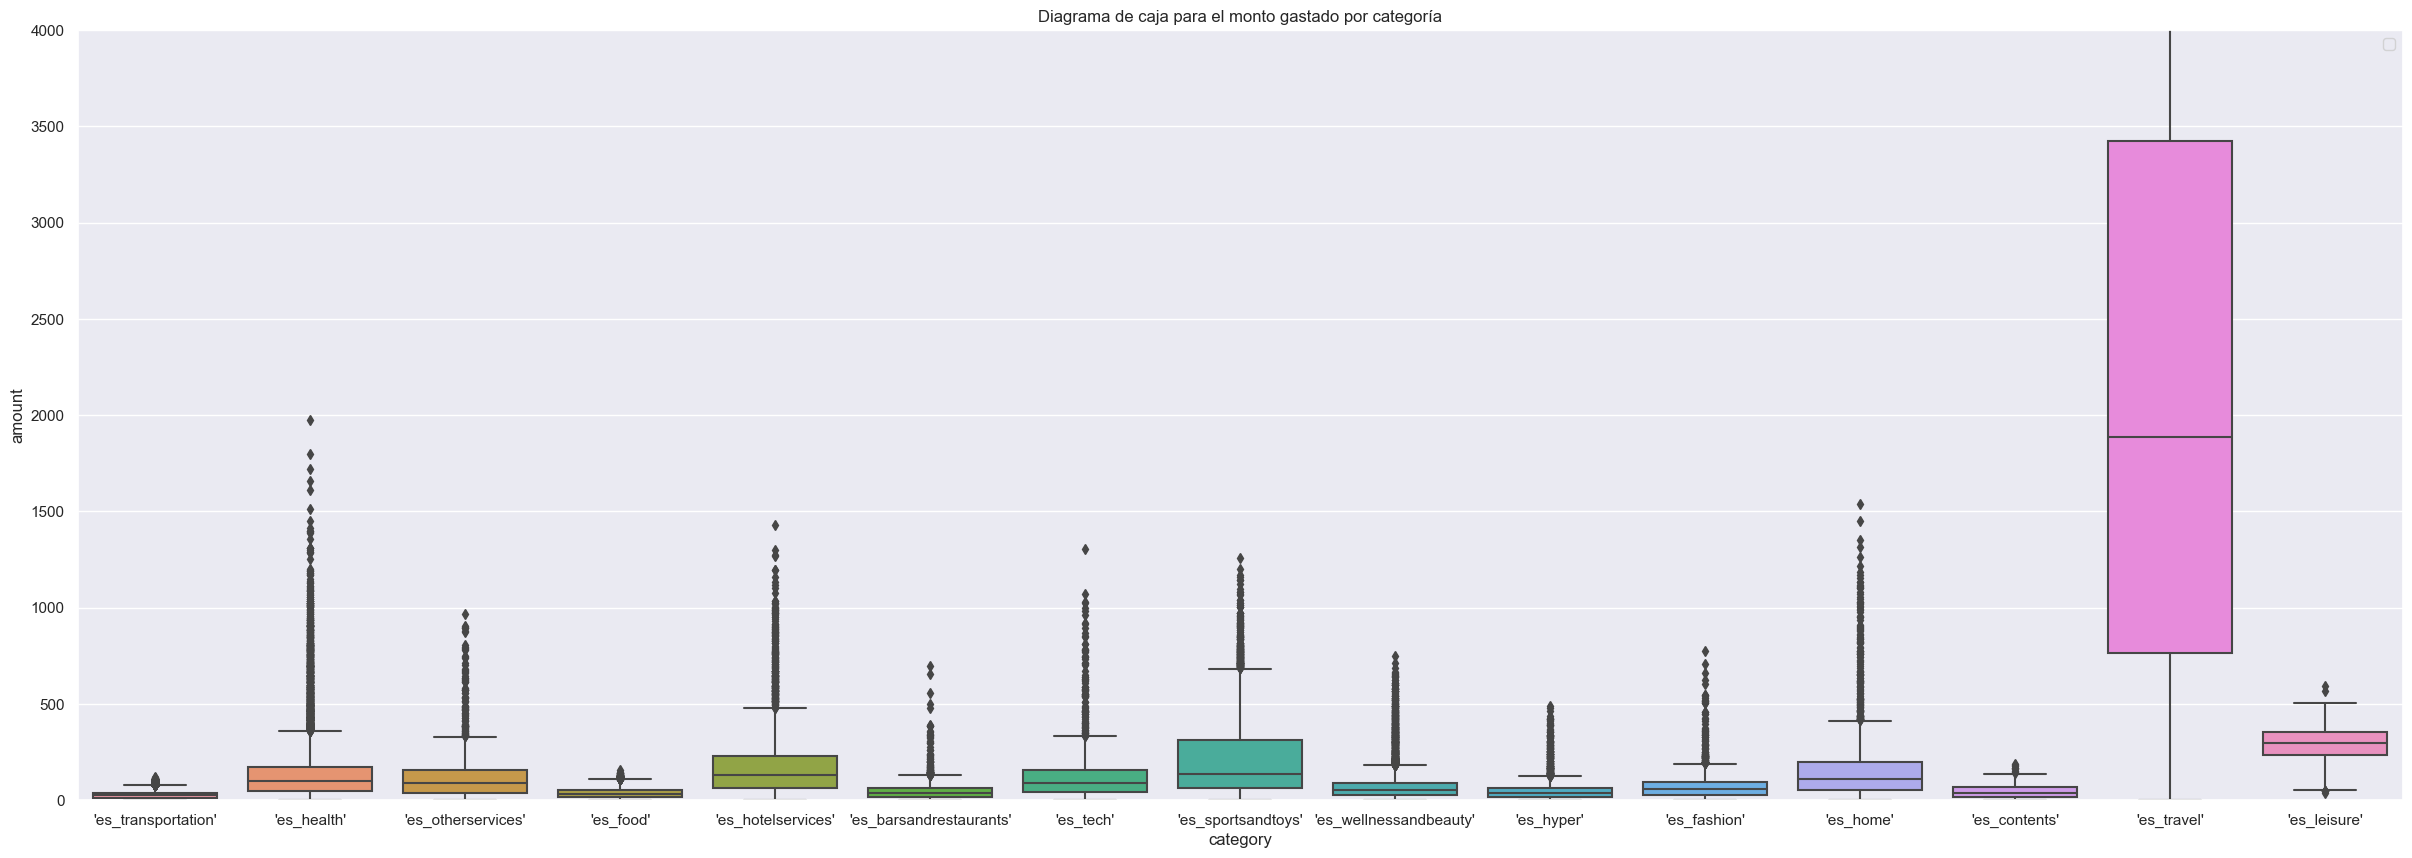

In [27]:
# Graficar histogramas de los montos en datos de fraude y no fraude
plt.figure(figsize=(30,10))  # Definir el tamaño de la figura
sns.boxplot(x=data.category, y=data.amount)  # Crear un gráfico de caja para el monto gastado en cada categoría
plt.title("Diagrama de caja para el monto gastado por categoría")  # Añadir título al gráfico
plt.ylim(0, 4000)  # Establecer los límites del eje Y para que el máximo sea 4000
plt.legend()  # Añadir la leyenda (aunque no es necesaria para un boxplot)
plt.show()  # Mostrar el gráfico

Los montos promedio gastados en las diferentes categorías son similares, oscilando entre 0 y 500 al descartar los valores atípicos. Sin embargo, la categoría de viajes se destaca considerablemente, mostrando montos mucho más elevados en comparación con el resto.

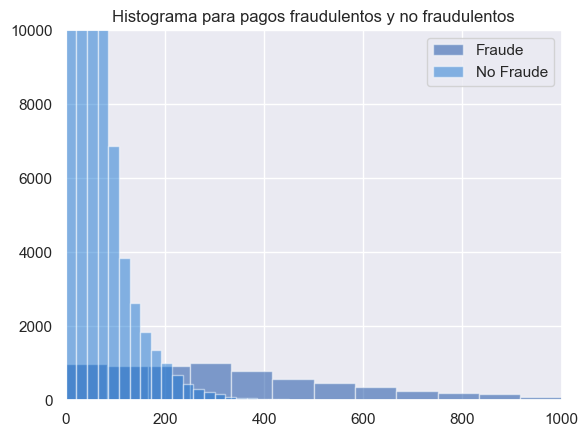

In [20]:
# Graficar histogramas de los montos en datos de fraude y no fraude
plt.hist(df_fraud.amount, alpha=0.5, label='Fraude', bins=100)  # Histograma para los montos de las transacciones fraudulentas
plt.hist(df_non_fraud.amount, alpha=0.5, label='No Fraude', bins=100)  # Histograma para los montos de las transacciones no fraudulentas
plt.title("Histograma para pagos fraudulentos y no fraudulentos")  # Añadir título al gráfico
plt.ylim(0, 10000)  # Establecer los límites del eje Y
plt.xlim(0, 1000)  # Establecer los límites del eje X
plt.legend()  # Mostrar la leyenda para diferenciar fraude y no fraude
plt.show()  # Mostrar el gráfico

Nuevamente podemos ver en el histograma que las transacciones fraudulentas son menores en cantidad, pero mayores en monto.

In [21]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


Parece que el fraude ocurre con mayor frecuencia en personas de 18 años o menos (categoría 0). ¿Podría ser porque los defraudadores piensan que las consecuencias serían menores si aparentan ser más jóvenes, o tal vez realmente son jóvenes?

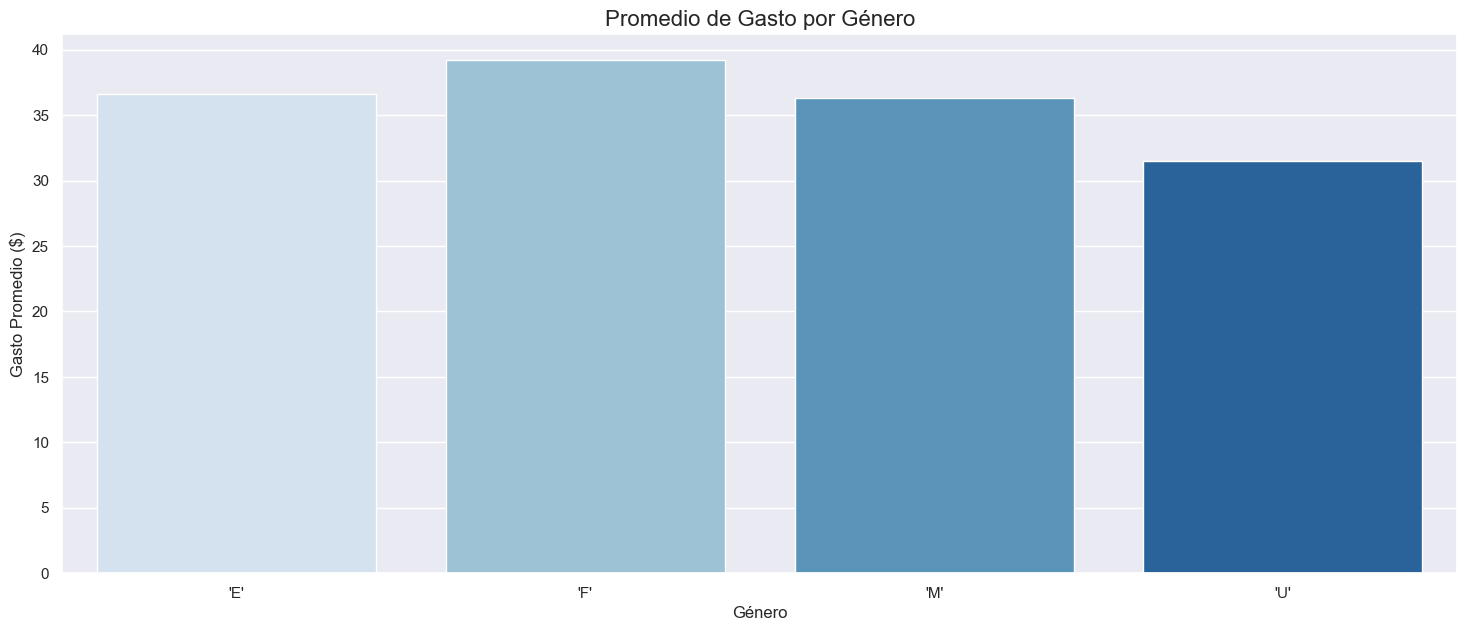

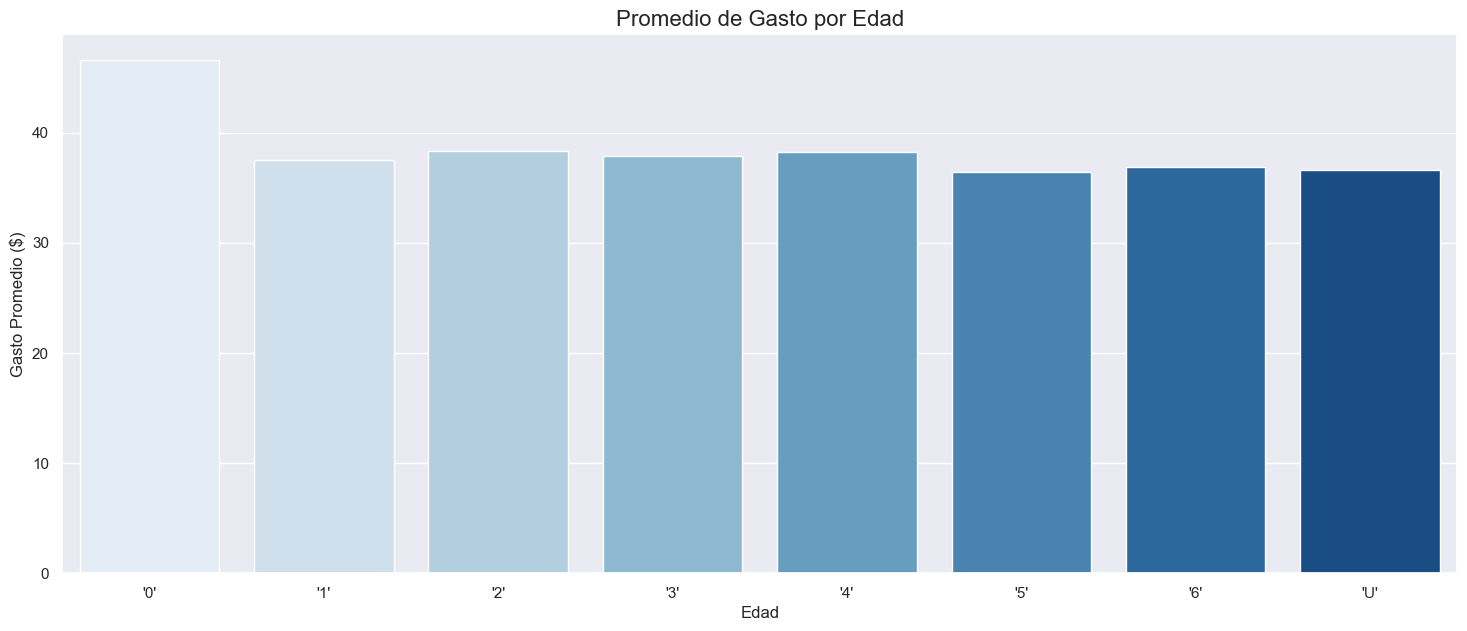

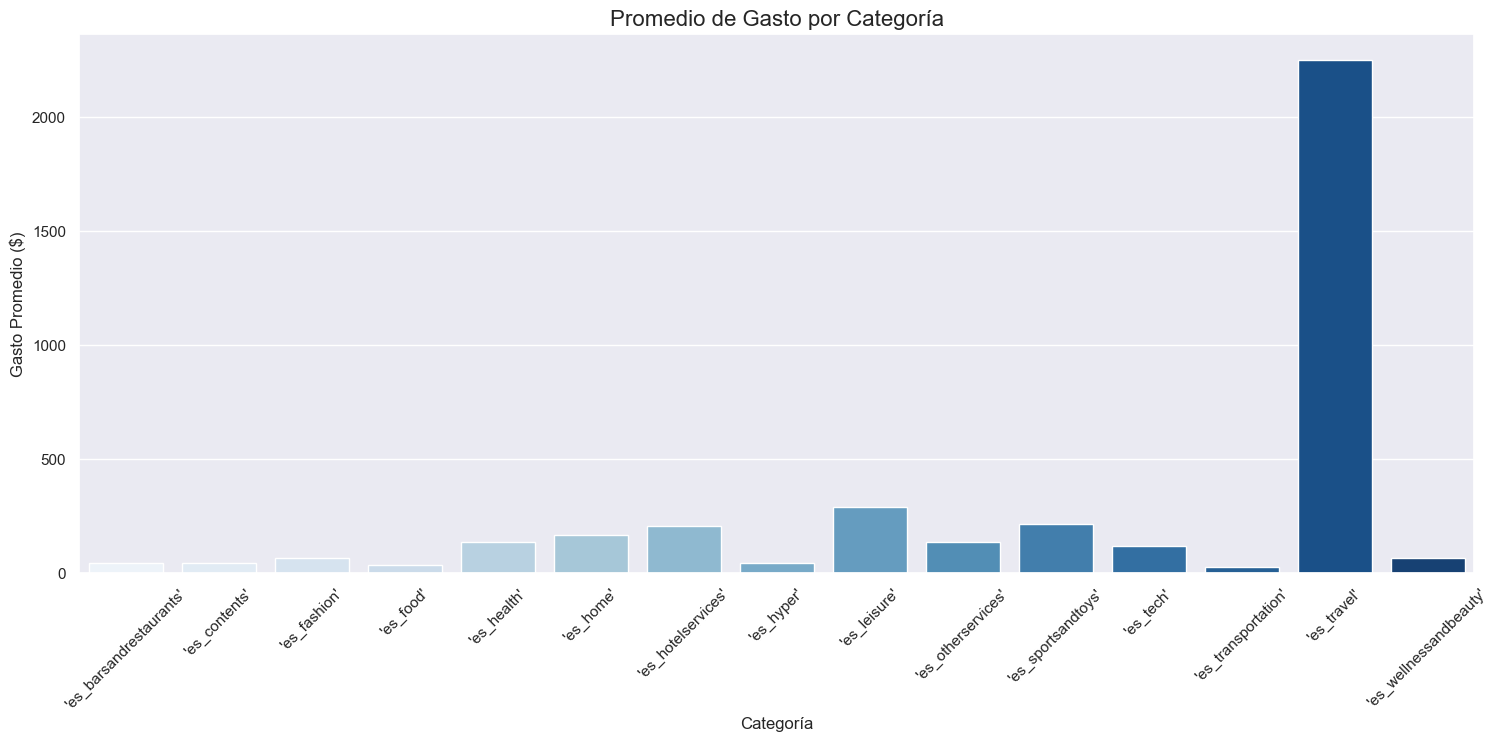

In [23]:
# Promedio de gasto por género
gender_spending = data.groupby('gender')['amount'].mean().reset_index(name='avg_spent')

# Promedio de gasto por edad
age_spending = data.groupby('age')['amount'].mean().reset_index(name='avg_spent')

# Promedio de gasto por categoría
category_spending = data.groupby('category')['amount'].mean().reset_index(name='avg_spent')

# Graficar los resultados
plt.figure(figsize=(18, 7))

sns.barplot(x='gender', y='avg_spent', data=gender_spending, palette='Blues')
plt.title("Promedio de Gasto por Género", fontsize=16)
plt.xlabel("Género")
plt.ylabel("Gasto Promedio ($)")
plt.show()

plt.figure(figsize=(18, 7))

sns.barplot(x='age', y='avg_spent', data=age_spending, palette='Blues')
plt.title("Promedio de Gasto por Edad", fontsize=16)
plt.xlabel("Edad")
plt.ylabel("Gasto Promedio ($)")
plt.show()

plt.figure(figsize=(18, 7))

sns.barplot(x='category', y='avg_spent', data=category_spending, palette='Blues')
plt.title("Promedio de Gasto por Categoría", fontsize=16)
plt.xlabel("Categoría")
plt.ylabel("Gasto Promedio ($)")
plt.xticks(rotation=45)
plt.show()


analizamos el gasto promedio por género, edad y categoría para identificar los mayores gastadores.

C:\Users\jadarve\AppData\Local\Temp\ipykernel_47504\4206077737.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['amount'], shade=True, color='#1976D2', alpha=0.5)


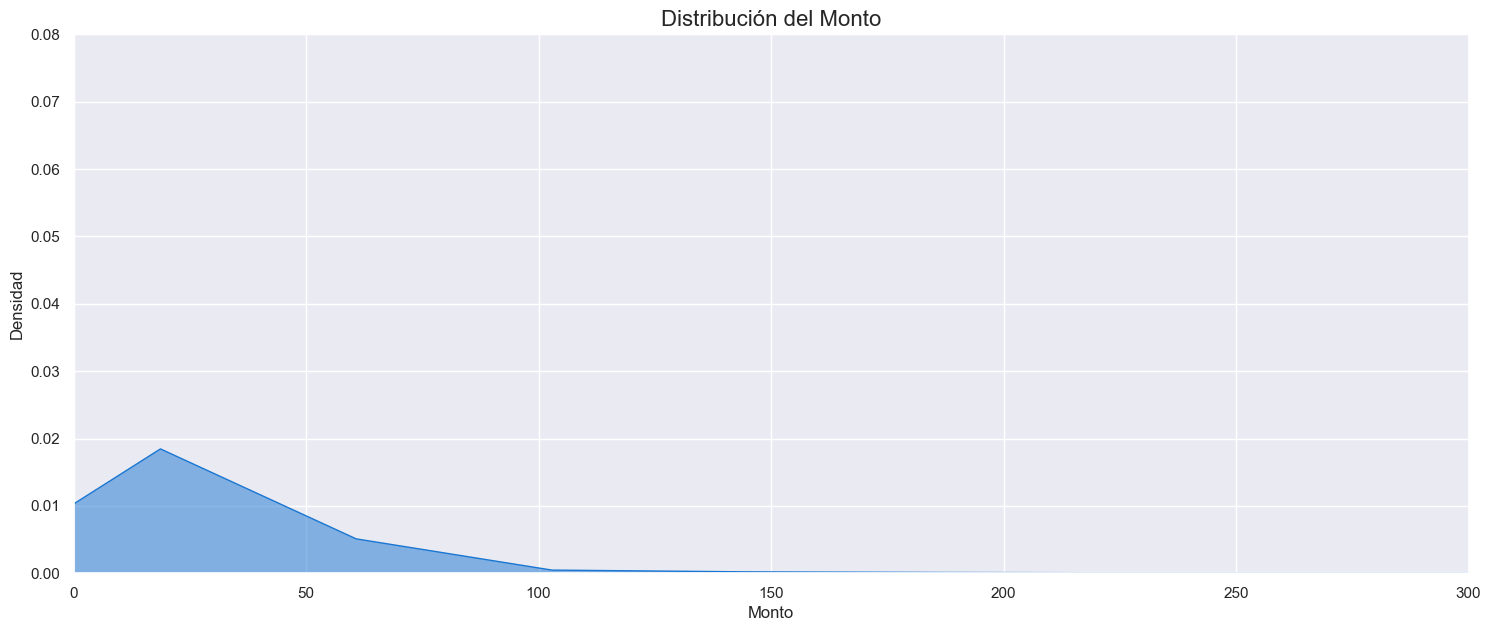

In [22]:
# Gráfico de la distribución del monto de las transacciones
plt.figure(figsize=(18, 7))
sns.kdeplot(data['amount'], shade=True, color='#1976D2', alpha=0.5)
plt.xlim(0, 300)
plt.ylim(0, 0.08)
plt.title("Distribución del Monto", fontsize=16)
plt.xlabel("Monto")
plt.ylabel("Densidad")
plt.show()

La distribución del monto de las transacciones en el conjunto de datos está extremadamente sesgada hacia la derecha. Más del 95% de las transacciones tienen un valor entre 1 y 100 dólares, pero el resto alcanzan valores extremadamente altos, con un máximo superior a los 8,000 dólares.

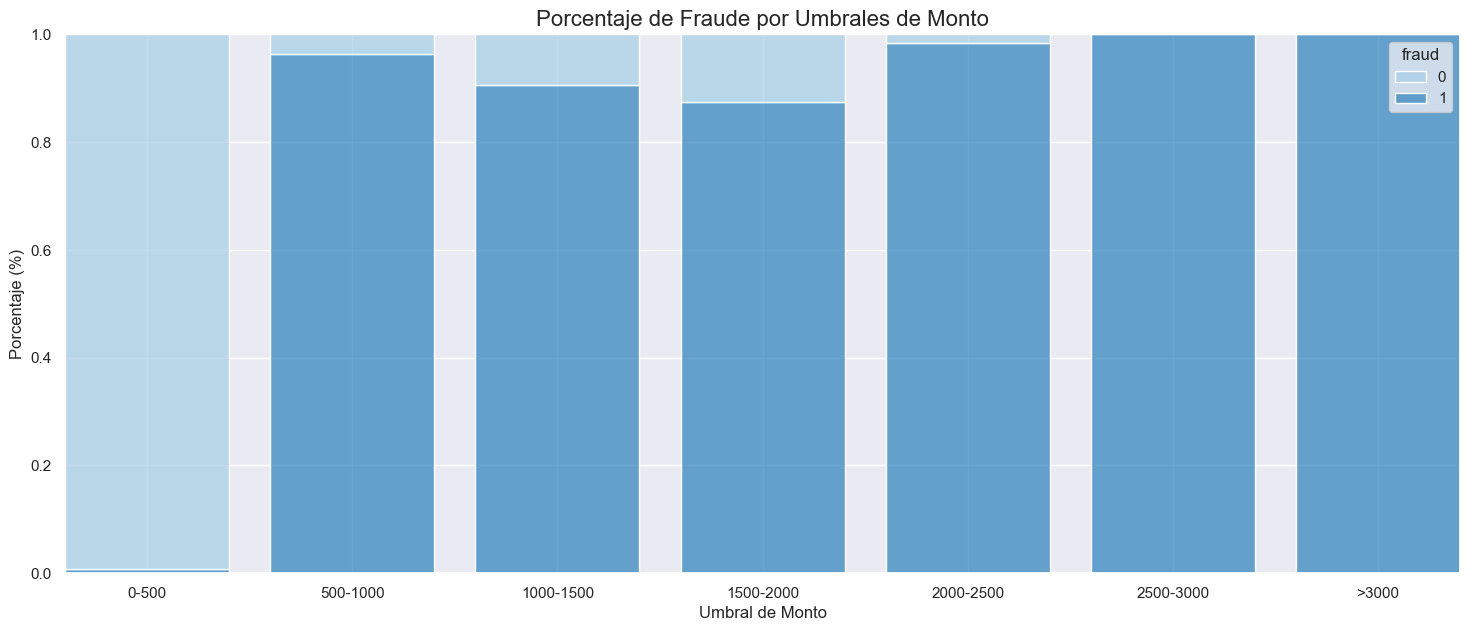

In [24]:
# Crear categorías de umbrales de monto
data['amount_thresh'] = pd.cut(data['amount'], bins=[0, 500, 1000, 1500, 2000, 2500, 3000, np.inf],
                               labels=["0-500", "500-1000", "1000-1500", "1500-2000", "2000-2500", "2500-3000", ">3000"])

# Graficar el porcentaje de fraude por umbral de monto
plt.figure(figsize=(18, 7))
sns.histplot(data=data, x="amount_thresh", hue="fraud", multiple="fill", palette="Blues", shrink=0.8)
plt.title("Porcentaje de Fraude por Umbrales de Monto", fontsize=16)
plt.xlabel("Umbral de Monto")
plt.ylabel("Porcentaje (%)")
plt.show()

El porcentaje de fraude en diferentes umbrales de monto es muy interesante. Hay casi ninguna transacción fraudulenta entre 1 y 500 dólares, pero por encima de este valor, el porcentaje de fraude salta al 90% o más.

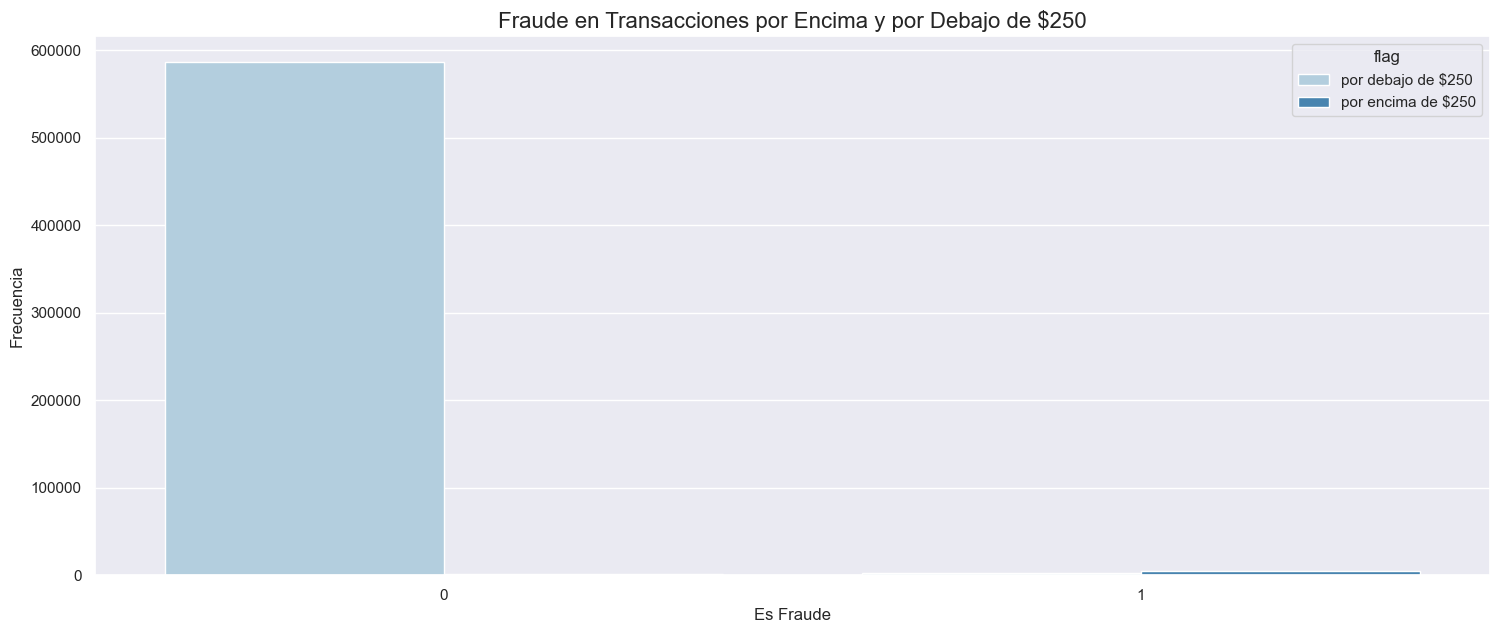

In [25]:
# Crear una bandera para transacciones por encima y por debajo de $250
data['flag'] = np.where(data['amount'] <= 250, "por debajo de $250", "por encima de $250")

# Graficar las transacciones fraudulentas y no fraudulentas por bandera
plt.figure(figsize=(18, 7))
sns.countplot(x="fraud", hue="flag", data=data, palette="Blues")
plt.title("Fraude en Transacciones por Encima y por Debajo de $250", fontsize=16)
plt.xlabel("Es Fraude")
plt.ylabel("Frecuencia")
plt.show()

comparamos la distribución del fraude en transacciones por encima y por debajo de $250.

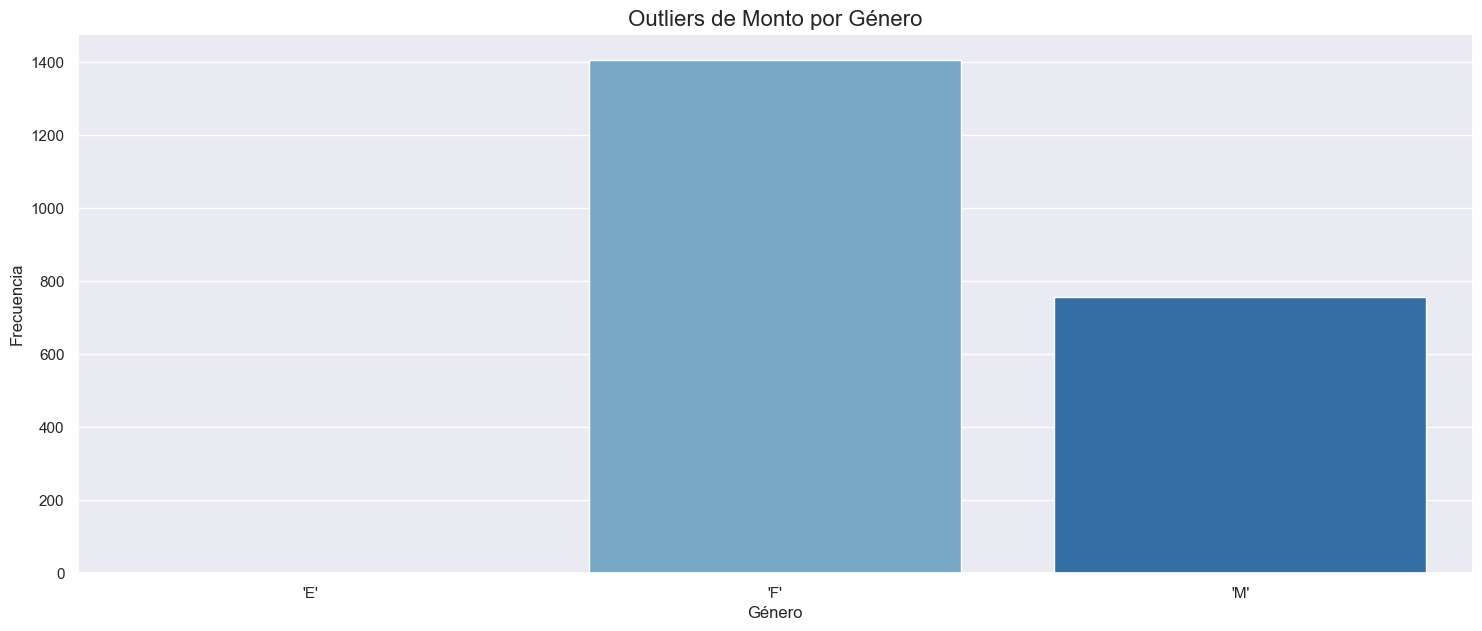

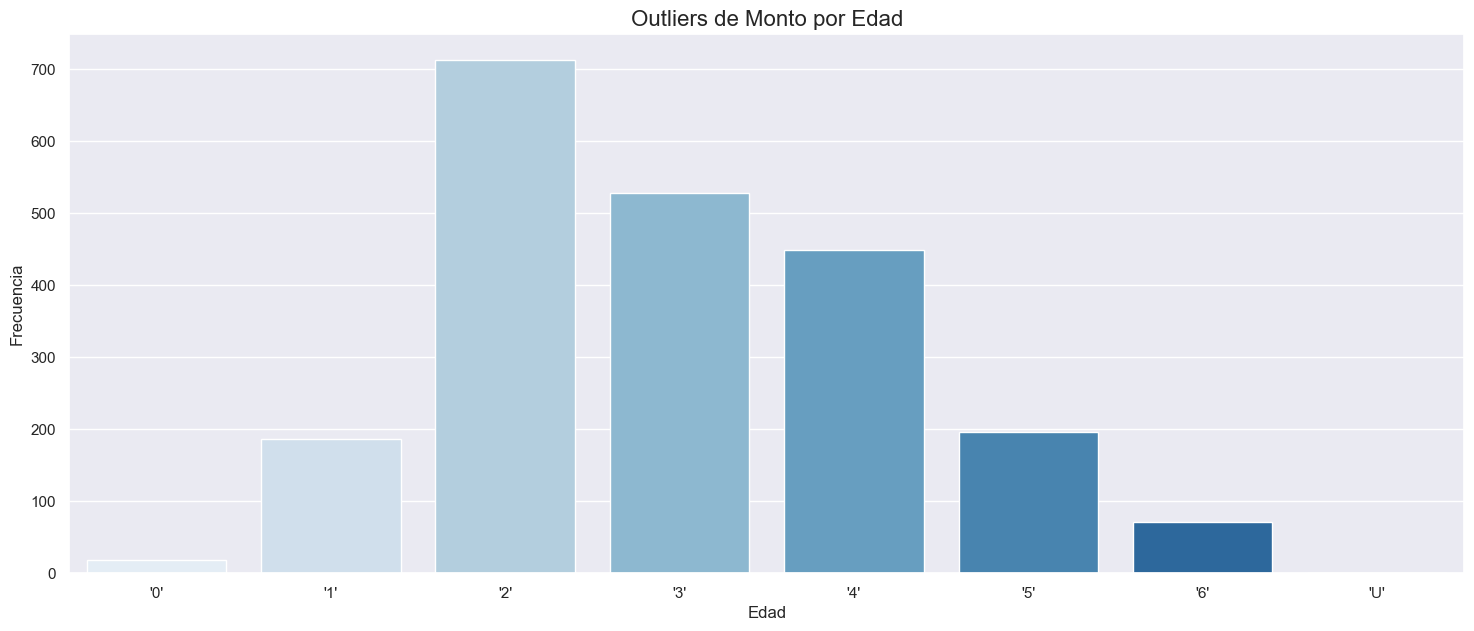

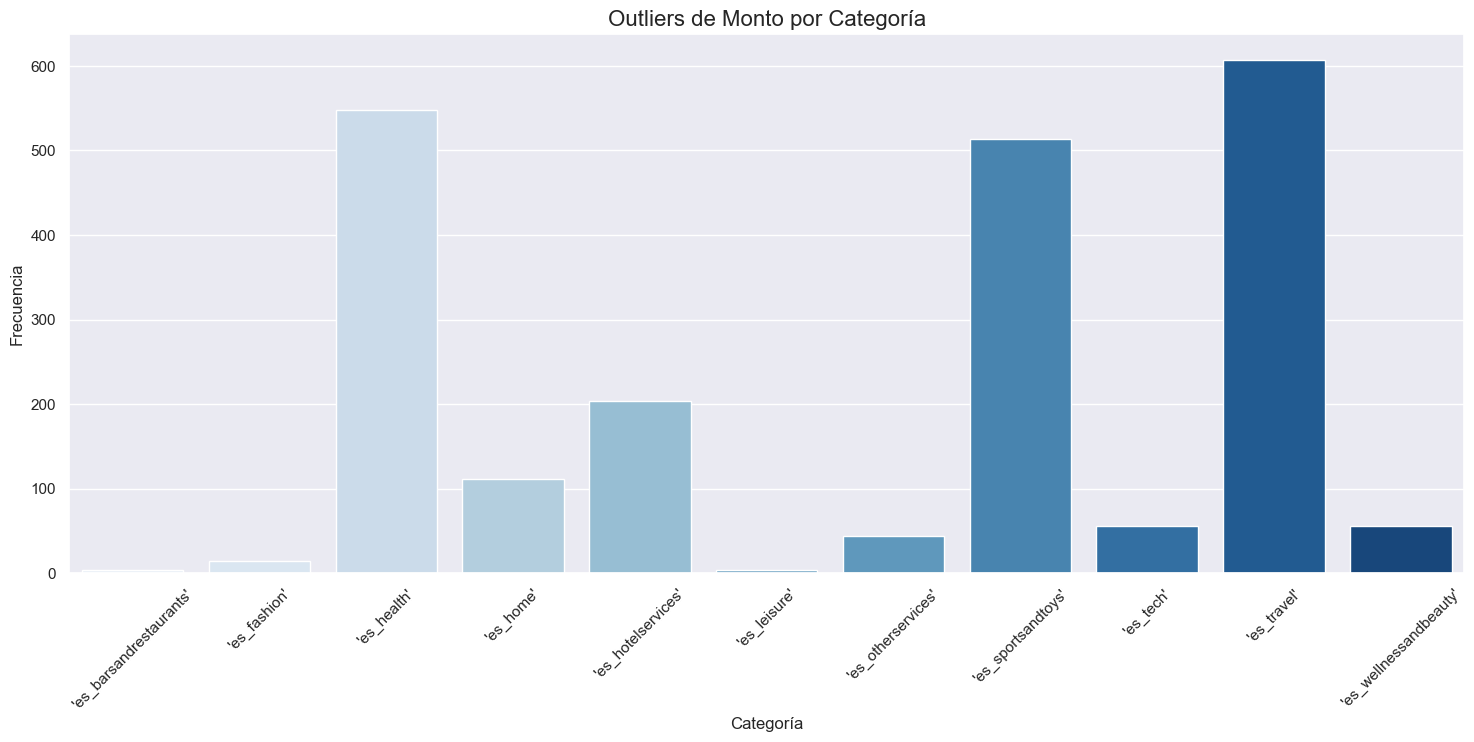

In [26]:
# Filtrar transacciones con montos superiores a $500
high_amount_data = data[data['amount'] > 500]

# Agrupar por género, edad y categoría
gender_outliers = high_amount_data.groupby('gender')['amount'].count().reset_index(name='n')
age_outliers = high_amount_data.groupby('age')['amount'].count().reset_index(name='n')
category_outliers = high_amount_data.groupby('category')['amount'].count().reset_index(name='n')

# Graficar los resultados
plt.figure(figsize=(18, 7))
sns.barplot(x='gender', y='n', data=gender_outliers, palette='Blues')
plt.title("Outliers de Monto por Género", fontsize=16)
plt.xlabel("Género")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(18, 7))
sns.barplot(x='age', y='n', data=age_outliers, palette='Blues')
plt.title("Outliers de Monto por Edad", fontsize=16)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(18, 7))
sns.barplot(x='category', y='n', data=category_outliers, palette='Blues')
plt.title("Outliers de Monto por Categoría", fontsize=16)
plt.xlabel("Categoría")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

Investigamos cómo lucen las transacciones extremadamente altas. La mayoría pertenecen a las categorías de viajes, salud, deportes y juguetes, realizadas por personas de entre 18 y 45 años, con más transacciones hechas por mujeres que por hombres entre estos valores atípicos.